<a href="https://colab.research.google.com/github/nickkolev97/FSL_STM/blob/main/unsupervised_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Firstly, install cuML which is like SKlearn but much faster on GPU.

In [1]:
# This gets the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing the rest of the RAPIDS 24.4.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com

        ***********************************************************************
        The pip install of RAPIDS is complete.
        
        Please do not run any further installation from the conda based installation methods, as they may cause issues!
        
        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files. 
            - If an installation failure persists when using the latest script, please make an issue on https://github.com/rapidsai-community/rapidsai-csp-utils
        ***********************************************************

Now install rapid CuML which is like sklearn but uses GPU for faster processing.

In [2]:
import cudf
cudf.__version__

'24.04.01'

In [3]:
import cuml
cuml.__version__

'24.04.00'

In [4]:
import cugraph
cugraph.__version__

'24.04.00'

In [5]:
import cuspatial
cuspatial.__version__

'24.04.00'

In [6]:
import cuxfilter
cuxfilter.__version__

'24.04.01'

In [7]:
%pip install patchify # this is used to turn a scan into crops much easier

In [8]:
import numpy as np
from matplotlib import pyplot as plt

# pytorch modules
import torch
import torch.nn as nn # nn class our model inherits from
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names

from torchvision.models.segmentation import fcn_resnet101, FCN_ResNet101_Weights

from PIL import Image

import patchify as pat

# Load data and prep it

In [56]:
# load scan
filled_gr = np.load(r'20181015-142255_STM_AtomManipulation-Gloucester Road-Si(100)-H--9_1_0.npy')
# pad it
pad_size = 64
filled_gr = np.pad(filled_gr, pad_size, mode='reflect')
# we pad it because when we stitch the patches back together we apply a sinusoidal window to each patch.
# this means the edges of the image fade away to 0. To avoid losing information, we pad it so the edges that
# go to zero contain unimportant information

In [57]:
filled_gr.shape

(1152, 1152)

In [58]:
def norm(array):
    '''normalise array so its values are between between 0 and 1
    and then make its mean 0 and standard deviation 1
    '''
    maximum  = np.max(array)
    minimum = np.min(array)
    arrayc = (array - minimum)/(maximum - minimum)
    mean = np.mean(arrayc)
    std = np.std(arrayc)
    arrayc = (arrayc - mean)/std
    return arrayc

def norm2(array):
    '''normalise array so its values are between between 0 and 1
    and then make its mean 0 and standard deviation 1.
    Array is 3d. Normalise it so each 2d image is normalised.
    '''
    maximums = np.max(array, axis = (1,2))
    minimums = np.min(array, axis = (1,2))
    arrayc = (array - minimums[:,None,None])/(maximums[:,None,None] - minimums[:,None,None])
    means = np.mean(arrayc, axis = (1,2))
    stds = np.std(arrayc, axis = (1,2))
    arrayc = (arrayc - means[:,None,None])/stds[:,None,None]
    return arrayc


In [59]:
def make_stitched(scan):
  '''
  turn scan into patches, then plane level each patch, and stitch back together. Then run KNN on the stitched patches.
  args: scan - numpy array of shape
  returns: stitched - numpy array of shape that is the original scan but with each 64*64 patch separately
                      plane levelled.
  '''
  res = scan.shape[0]
  # define patches
  patch_size = 64
  overlap = patch_size//2
  patches = pat.patchify(scan, (patch_size,patch_size), step=patch_size-overlap)
  patches = np.reshape(patches, (-1,patch_size,patch_size))
  # normalise patches
  patches = norm2(patches)
  # apply sinusoidal window to each patch in x and y direction
  patches = patches*np.sin(np.linspace(0,np.pi,patch_size))*np.expand_dims(np.sin(np.linspace(0,np.pi,patch_size)),axis=1)
  # reshape patches to shape necessary for unpatchify
  dim0 = np.sqrt(patches.shape[0]).astype(int)

  patches = np.reshape(patches, (dim0,dim0,patch_size,patch_size))
  # stitch patches back together
  stitched = np.zeros((res, res))
  for i in range(dim0):
      for j in range(dim0):
          stitched[i*overlap:(i*overlap)+patch_size, j*overlap:(j*overlap)+patch_size] = stitched[i*overlap:(i*overlap)+patch_size, j*overlap:(j*overlap)+patch_size] + patches[i,j,:,:]

  stitched = stitched[pad_size:-pad_size,pad_size:-pad_size]
  # flatten stitched patches
  flat_stitched = np.expand_dims(stitched.flatten(), axis=0)

  return flat_stitched, stitched, patches

In [62]:
# flatten the scan
flat_stitched_gr, stitched_gr, patches_gr = make_stitched(filled_gr)

In [63]:
#del(flat_stitched_gr, stitched_gr) # if they're not needed, can delete to free up memory

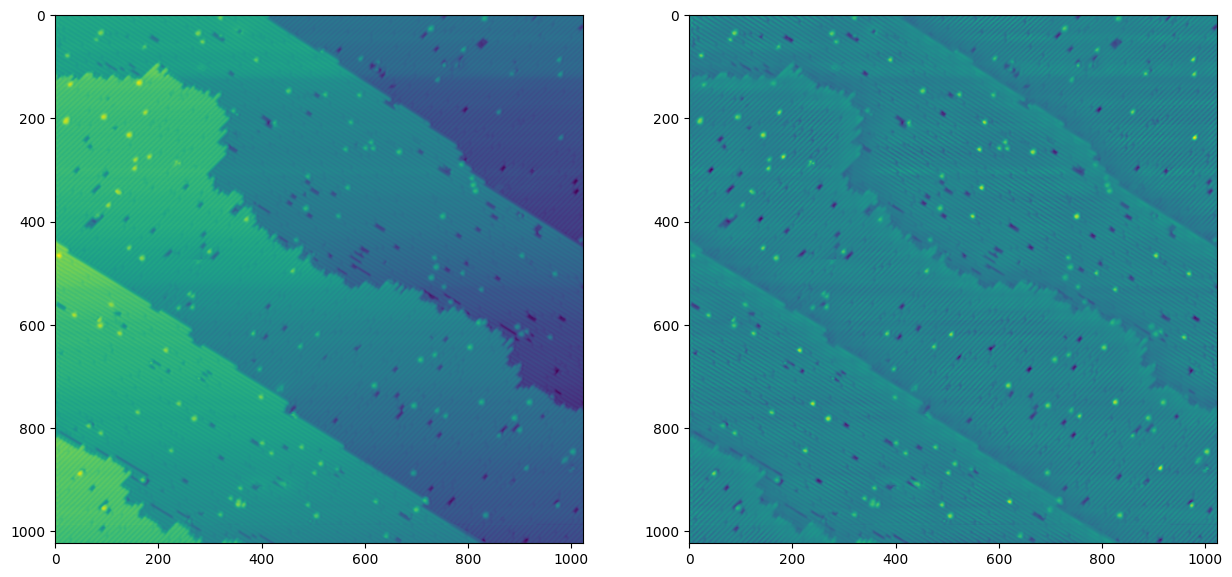

In [64]:
# plot of scan before processing and after
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
ax[0].imshow(filled_gr[pad_size:-pad_size,pad_size:-pad_size])
ax[1].imshow(stitched_gr)
plt.show()

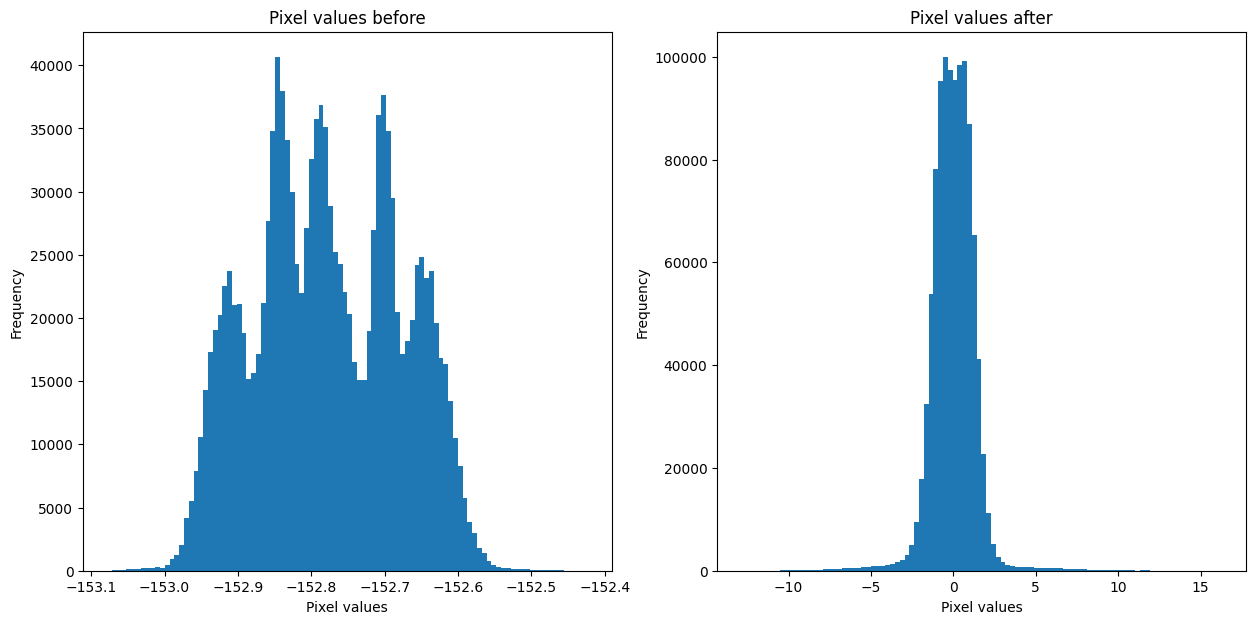

In [65]:
# plot the pixel values of the two scans, show how it now has a distribution better centrered around average.
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)
ax[0].set_title('Pixel values before')
ax[1].set_title('Pixel values after')
ax[0].hist(filled_gr.reshape(-1,1), bins=100)
ax[1].hist(stitched_gr.reshape(-1,1), bins=100)
ax[0].set_xlabel('Pixel values')
ax[1].set_xlabel('Pixel values')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
plt.show()

# Initialize model for segmentation

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [16]:
## Initialize model with the best available weights
weights = FCN_ResNet101_Weights.DEFAULT
base_model = fcn_resnet101(weights=weights)
base_model.eval()

# Disable gradient computation for all layers (just makes it so it takes up less memory to predict)
for param in base_model.parameters():
    param.requires_grad = False


In [17]:
class backbone(nn.Module):
    '''
    Feature extractor model that takes the output of the first and second layer of the resnet101 and upsamples them to
    same size as input.
    '''
    def __init__(self,model,layers):
      super().__init__()
      self.model = create_feature_extractor(model, layers)

    def forward(self, x, res=None):
      if res == None:
        res = x.shape[-1]

      # extract features
      out = self.model(x)

      # upsample feature maps that are lower res
      features = []
      for v in out.values():
        if v.shape!=res:
          v = transforms.Resize(res)(v)
        features.append(v.squeeze(0))

      # stack all feature maps
      if len(features[0].shape) == 4:
        full_output = torch.hstack( features )
      if len(features[0].shape)==3:
        full_output = torch.vstack( features )

      return full_output

In [17]:
# print the layer names of the model
get_graph_node_names(base_model)

(['x',
  'getattr',
  'getitem',
  'backbone.conv1',
  'backbone.bn1',
  'backbone.relu',
  'backbone.maxpool',
  'backbone.layer1.0.conv1',
  'backbone.layer1.0.bn1',
  'backbone.layer1.0.relu',
  'backbone.layer1.0.conv2',
  'backbone.layer1.0.bn2',
  'backbone.layer1.0.relu_1',
  'backbone.layer1.0.conv3',
  'backbone.layer1.0.bn3',
  'backbone.layer1.0.downsample.0',
  'backbone.layer1.0.downsample.1',
  'backbone.layer1.0.add',
  'backbone.layer1.0.relu_2',
  'backbone.layer1.1.conv1',
  'backbone.layer1.1.bn1',
  'backbone.layer1.1.relu',
  'backbone.layer1.1.conv2',
  'backbone.layer1.1.bn2',
  'backbone.layer1.1.relu_1',
  'backbone.layer1.1.conv3',
  'backbone.layer1.1.bn3',
  'backbone.layer1.1.add',
  'backbone.layer1.1.relu_2',
  'backbone.layer1.2.conv1',
  'backbone.layer1.2.bn1',
  'backbone.layer1.2.relu',
  'backbone.layer1.2.conv2',
  'backbone.layer1.2.bn2',
  'backbone.layer1.2.relu_1',
  'backbone.layer1.2.conv3',
  'backbone.layer1.2.bn3',
  'backbone.layer1.2.add

In [18]:
# define feature extractor
resnet_bb = backbone(base_model, ['backbone.layer1', 'backbone.layer2'])

In [19]:
def extract_features(scan):
  '''
  Does preprocessing and postprocessing for feature extraction of scan.
  This is for extracting features without any upsampling (or downsampling) of image.
  args: scan - numpy array
  returns: output_of_scan - feature vectors of pixels of the scan (shape is (res*res, dimension of feature vectors))
  '''
  # now try extracting features from stitched and then running knn on them
  # normalise scan
  scan_norm = norm(scan)
  # turn to tensor and reshape to (3, 520,520)
  scan_norm = torch.tensor(scan_norm).float()
  scan_norm = torch.stack([scan_norm,scan_norm,scan_norm]).unsqueeze(0)
 # scan_norm = transforms.Resize(520)(scan_norm)
  #extract features
  output_of_scan = resnet_bb(scan_norm)
  # flatten and turn to numpy array
  output_of_scan = torch.flatten(output_of_scan, start_dim=1,end_dim=2).detach().numpy()
  return output_of_scan


def extract_patches_features(scan):
  '''
  Extracts feature fectors of upsampled image.
  Due to memory issues, we can't just upsample to 4096*4096 and then extract features.
  We turn scan into crops, upsample those, then extract features in batches, before stitching
  those back together (after applying a sinusoidal window to them to make the borders smooth).

  args: scan - numpy array
  returns: output_of_scan - tensor with feature vectors of pixels of the scan

  '''
  res = scan.shape[0]
  # get patches
  _,_,patches = make_stitched(scan)
  # try extracting features from each patch
  patch_size = 64
  n = patches.shape[0]
  # normalise patches
  patches = np.reshape(patches, (-1,patch_size,patch_size))
  norm_patches = norm2(patches)
  # turn to tensor and reshape to (3, 520,520)
  norm_patches = torch.tensor(norm_patches).float()
  norm_patches = torch.transpose(torch.stack([norm_patches,norm_patches,norm_patches]), 0,1)
  # resize to (num_patches, 3, 520, 520)
  norm_patches = transforms.Resize(520)(norm_patches)
  # extract features
  features = {}
  for i in range(n):
    with torch.no_grad():
      print('Extracting batch {} out of {}'.format(i,n))
      features[i] = resnet_bb(norm_patches[i*n:(i+1)*n,:,:,:], patch_size)

  #change shape of any that have one dim less
  for key in features.keys():
    if len(features[key].shape)==3:
      features[key] = features[key].unsqueeze(0)

  output_of_patches = torch.concat(list(features.values()), dim=0)
  # delete features as it takes up a lot of memory
  del(features)
  # stitch back together with sinusoidal window
  output = output_of_patches.detach().numpy()
  del(output_of_patches)

  # stitch back together with sinusoidal window
  # define patches
  overlap = patch_size//2
  dim0 = np.sqrt(output.shape[0]).astype(int)
  feature_space_dim = output.shape[1]

  output = np.reshape(output, (dim0, dim0, feature_space_dim ,patch_size,patch_size))

  # apply sinusoidal window to each patch in x and y direction
  # even though for loops are slower than numpy broadcasting, the broadcasting requires a huge np.sin array to be stored in memory which crashes the kernel
  for i in range(dim0):
    for j in range(dim0):
      output[i,j, :, :,:] = output[i,j,: , :,:]*np.sin(np.linspace(0,np.pi,patch_size))*np.expand_dims(np.sin(np.linspace(0,np.pi,patch_size)),axis=1)

 # reshape patches to shape necessary for unpatchify
  # stitch patches back together
  stitched = torch.zeros((feature_space_dim , res,res))
  for i in range(dim0):
      for j in range(dim0):
          stitched[:,i*overlap:(i*overlap)+patch_size, j*overlap:(j*overlap)+patch_size] = stitched[:,i*overlap:(i*overlap)+patch_size, j*overlap:(j*overlap)+patch_size] + output[i,j,:,:,:]

  return stitched[:,overlap:-overlap,overlap:-overlap]

# Segment image. We show 3 different segmentation methods:
### - KNN on bare pixels
### - KNN on pixels' feature vectors
### - upsample image, then apply KNN on pixels' feature vectors

------------------------------------------------------------------

### 1) KNN on bare pixels

In [66]:
# apply knn to stitched gr
# Choose the number of clusters (for example, 3)
n_clusters = 4

kmeans = cuml.KMeans(n_clusters=n_clusters)
kmeans.fit(flat_stitched_gr.T)

# The cluster labels for each data point can be found in kmeans.labels_
print(kmeans.labels_)

[1 1 1 ... 3 3 1]


In [69]:
# reshape flattened into full image
segmented_1 = np.reshape(kmeans.labels_, (1024,1024))

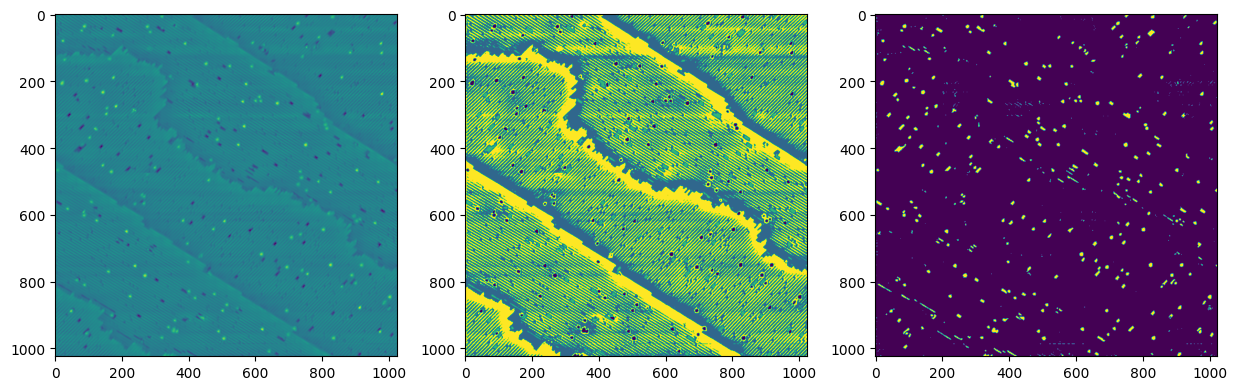

In [71]:
# plot segmented and stitched side by side
fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 15)
ax[0].imshow(stitched_gr)
ax[1].imshow(segmented_1)
ax[2].imshow((segmented_1==0)+(segmented_1==2))
plt.show()

## 2) KNN on feature vectors

In [72]:
features_gr = extract_features(stitched_gr)


In [73]:
#del(output_gr) # delete if not needed to free up memory

In [74]:
# run knn on output of stitched
n_clusters = 5

kmeans = cuml.KMeans(n_clusters=n_clusters)
kmeans.fit(features_gr.T)

# The cluster labels for each data point can be found in kmeans.labels_
print(kmeans.labels_)

[4 4 4 ... 0 0 0]


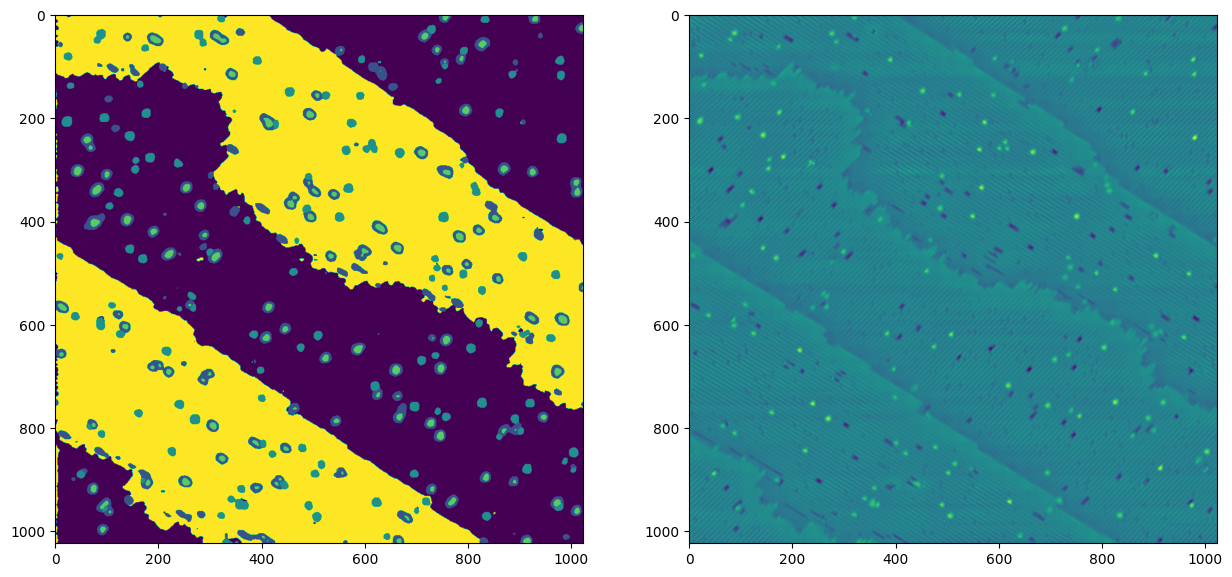

In [76]:
# output with features extracted from layer1 and layer2
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
ax[0].imshow(np.reshape(kmeans.labels_, (1024,1024)))
ax[1].imshow(stitched_gr)
plt.show()

## 3) Upsample, then extract features and do KNN

In [20]:
patch_features_gr = extract_patches_features(filled_gr[::2,::2])

Extracting batch 0 out of 17
Extracting batch 1 out of 17
Extracting batch 2 out of 17
Extracting batch 3 out of 17
Extracting batch 4 out of 17
Extracting batch 5 out of 17
Extracting batch 6 out of 17
Extracting batch 7 out of 17
Extracting batch 8 out of 17
Extracting batch 9 out of 17
Extracting batch 10 out of 17
Extracting batch 11 out of 17
Extracting batch 12 out of 17
Extracting batch 13 out of 17
Extracting batch 14 out of 17
Extracting batch 15 out of 17
Extracting batch 16 out of 17


In [21]:
# flatten stitched patches
flat_stitched = np.reshape(patch_features_gr, (768,-1)).detach().numpy()

In [ ]:
#del(patch_features_s) # delete if not being used

In [22]:
# knn on it
n_clusters = 7

kmeans = cuml.KMeans(n_clusters=n_clusters)
kmeans.fit(flat_stitched.T)
print(kmeans.n_features_in_)
# The cluster labels for each data point can be found in kmeans.labels_
print(kmeans.labels_)

768
[6 6 0 ... 6 6 6]


In [39]:
final_output_ = np.reshape(kmeans.labels_==5, (512,512)) + np.reshape(kmeans.labels_==3 , (512,512 )) + np.reshape(kmeans.labels_==1 , (512,512))
final_output = np.reshape(kmeans.labels_ , (512, 512))

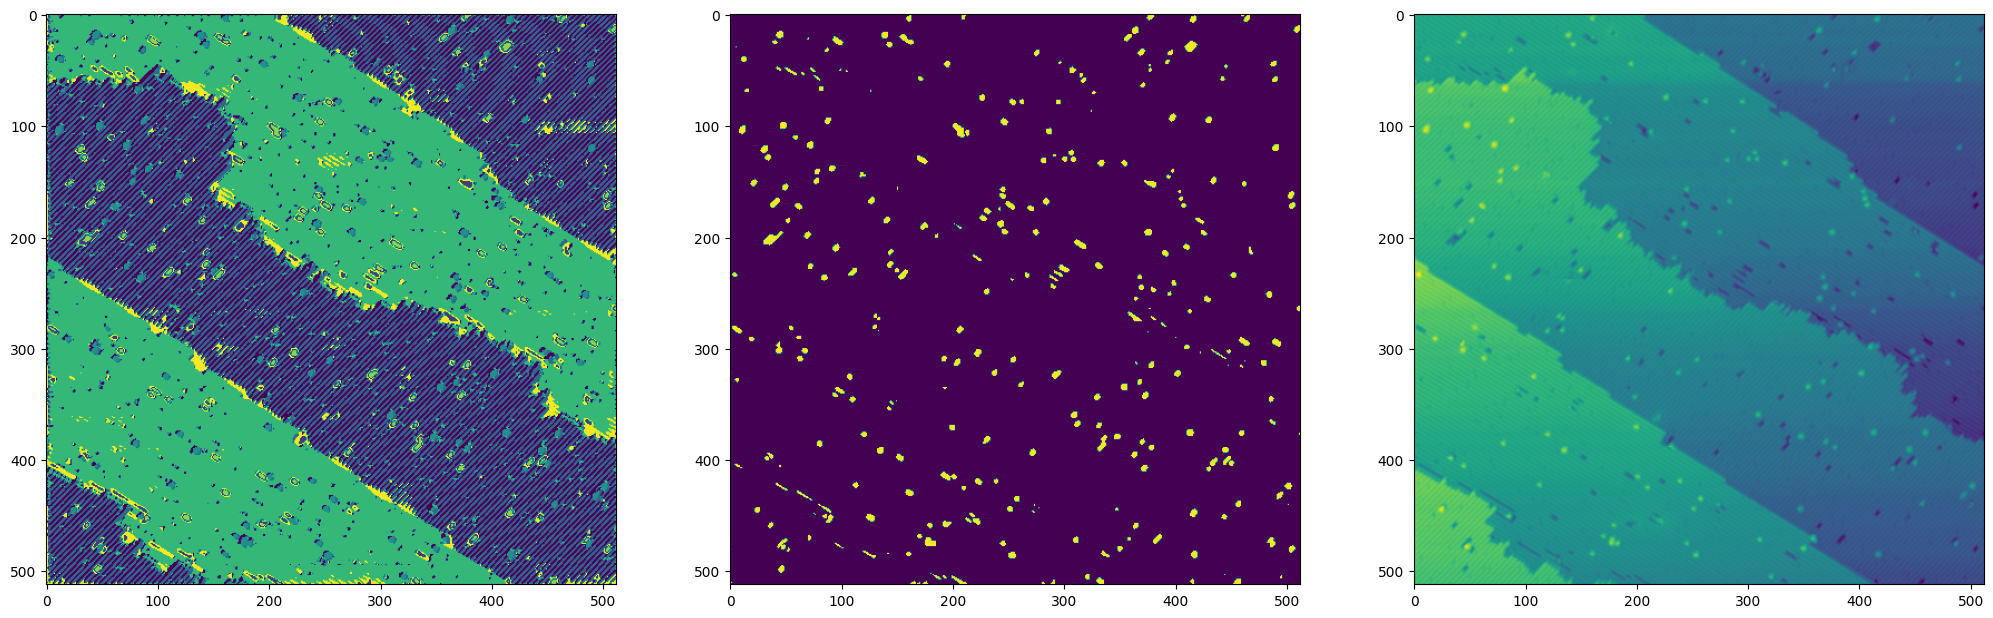

In [41]:
# output with features extracted from layer1 and layer2
fig, ax = plt.subplots(1,3)
fig.set_size_inches(25, 25)
ax[0].imshow(final_output)
ax[1].imshow(final_output_>0)
ax[2].imshow(filled_gr[pad_size:-pad_size,pad_size:-pad_size])
plt.show()